# Logistic Regression on Amazon fine food dataset

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
To perform Logistic regression using L2 regularization on different vectors like BOW, Tf-idf, Avg-W2vec & Tf-idf_W2vec.

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
#Importing Train and test dataset
train_data=pd.read_csv("E:/Applied AI assignments/Amazon_fine_train_data.csv")
test_data=pd.read_csv("E:/Applied AI assignments/Amazon_fine_test_data.csv")

In [4]:
train_data=train_data.astype(str)
test_data=test_data.astype(str)

In [4]:
train_data.shape

(80000, 13)

In [6]:
train_data['Score'].value_counts()

positive    70407
negative     9593
Name: Score, dtype: int64

In [7]:
test_data.shape

(20000, 13)

In [8]:
test_data['Score'].value_counts()

positive    17322
negative     2678
Name: Score, dtype: int64

In [5]:
#Train data
y_train = train_data['Score']
x_train = train_data['CleanedText']

#Test data
y_test = test_data['Score']
x_test = test_data['CleanedText'] 

In [6]:
#Replacing Positive score with 0 and negative score with 1
y_train.replace('negative',1,inplace=True)
y_train.replace('positive',0,inplace=True)

y_test.replace('negative',1,inplace=True)
y_test.replace('positive',0,inplace=True)

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm

### Applying L2 regularization

####  Randomised CV using L2

In [53]:
gamma_range = [0.0000000001,0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,5,10,15,20,30,40,50]
T= TimeSeriesSplit(n_splits=5)
weight=[None,'balanced']

param_distributions = dict(C=gamma_range,class_weight=weight)
print(param_distributions)

# instantiate and fit the grid
grid = RandomizedSearchCV(LogisticRegression(penalty='l2'), param_distributions, cv=T, scoring='f1', return_train_score=False,n_jobs=-1)

{'C': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5, 10, 15, 20, 30, 40, 50], 'class_weight': [None, 'balanced']}


#### Binary Bow

In [9]:
count_vect = CountVectorizer(binary=True)

#Train data
vocabulary = count_vect.fit(x_train) #in scikit-learn
Bow_x_train= count_vect.transform(x_train)
print("the type of count vectorizer ",type(Bow_x_train))
print("the shape of out text BOW vectorizer ",Bow_x_train.get_shape())
print("the number of unique words ", Bow_x_train.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (80000, 33433)
the number of unique words  33433


In [10]:
#Test data
Bow_x_test = count_vect.transform(x_test)
print("the type of count vectorizer ",type(Bow_x_test))
print("the shape of out text BOW vectorizer ",Bow_x_test.get_shape())
print("the number of unique words ", Bow_x_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 33433)
the number of unique words  33433


In [11]:
#Standardizing Bow_x_train and Bow_x_test
from sklearn.preprocessing import StandardScaler
Scaler=StandardScaler(with_mean=False)
Bow_x_train = Scaler.fit_transform(Bow_x_train)
Bow_x_test = Scaler.transform(Bow_x_test)

print(Bow_x_train.shape)
print(Bow_x_test.shape)

(80000, 33433)
(20000, 33433)


#### Fitting Grid Search CV on BOW 

In [12]:
grid.fit(Bow_x_train, y_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.6401387857438695
{'class_weight': 'balanced', 'C': 0.0001}


Text(0,0.5,'Cross-Validated Error')

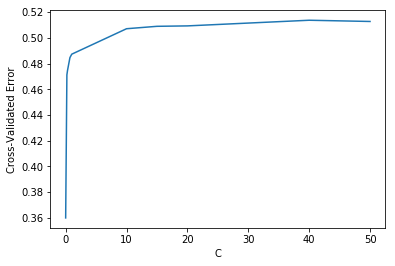

In [13]:
#Plotting C v/s CV_error
a=pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
a['C'] = [d.get('C') for d in a['params']]
b=a.sort_values(['C'])
CV_Error=1-b['mean_test_score']
C =b['C']


plt.plot(C,CV_Error)
plt.xlabel('C')
plt.ylabel('Cross-Validated Error')

In [14]:

#{'class_weight': 'balanced', 'C': 0.0001}
LR_optimal=LogisticRegression(penalty='l2',C=0.0001,class_weight='balanced')

# fitting the model
LR_optimal.fit(Bow_x_train, y_train)

# predict the response
pred_bow = LR_optimal.predict(Bow_x_test)

# evaluate f1_score
f1_score = f1_score(y_test, pred_bow)

# Train & Test Error
print("The overall f1_score for the Train Data is : ", metrics.f1_score(y_train,LR_optimal.predict(Bow_x_train)))
print("The overall f1_score for the Test Data is : ", metrics.f1_score(y_test,pred_bow))

The overall f1_score for the Train Data is :  0.8089229382604777
The overall f1_score for the Test Data is :  0.675998091299507


Pertubation test

In [15]:
# Re-training the model after adding noise
Epsilon = np.random.normal(loc=0,scale =0.01)
Noise_Bow_x_train=Bow_x_train
Noise_Bow_x_train.data+=Epsilon

In [16]:
Noise_Bow_x_train.shape

(80000, 33433)

In [17]:

#{'class_weight': 'balanced', 'C': 0.0001}
LR_optimal_noise=LogisticRegression(penalty='l2',C=0.0001,class_weight='balanced')

# fitting the model
LR_optimal_noise.fit(Noise_Bow_x_train, y_train)

# predict the response
pred_bow = LR_optimal_noise.predict(Bow_x_test)

# evaluate f1_score
f1_score = f1_score(y_test, pred_bow)

# Train & Test Error
print("The overall f1_score for the Train Data is : ", metrics.f1_score(y_train,LR_optimal.predict(Noise_Bow_x_train)))
print("The overall f1_score for the Test Data is : ", metrics.f1_score(y_test,pred_bow))

The overall f1_score for the Train Data is :  0.8088692595430168
The overall f1_score for the Test Data is :  0.675998091299507


In [18]:
#Features
feature_names = np.array(vocabulary.get_feature_names())
feature_names.shape

(33433,)

In [31]:
#Weights before adding noise
LR_optimal.coef_.shape

(1, 33433)

In [32]:
#Weights after adding noise
LR_optimal_noise.coef_.shape

(1, 33433)

In [37]:
merge_arr = np.concatenate([LR_optimal.coef_, LR_optimal_noise.coef_], axis=0)
merge=pd.DataFrame(data=merge_arr,columns=feature_names).transpose()
merge[2]=((merge[1]-merge[0])/merge[0])*100
merge

,0,1,2
aaa,-0.001722,-0.001722,0.002999
aaaaaaaaagghh,-0.002087,-0.002087,-0.012497
aaaaah,-0.002006,-0.002006,0.005672
aaaaahhhhhhhhhhhhhhhh,-0.000765,-0.000765,0.000203
aaaah,-0.000964,-0.000964,-0.003298
aaah,-0.001224,-0.001224,-0.004986
aachen,0.005927,0.005927,-0.008612
aad,-0.000364,-0.000364,-0.071263
aadp,-0.001017,-0.001017,-0.024636
aafco,-0.000879,-0.000878,-0.090446


In [38]:
merge[merge[2]>30].shape

(3, 3)

3 features out of 33433 shows percentage change > 30 post pertubation test i.e 0.0089%

We can say that our data isn't much affected by multicollinearity

In [40]:
feature_names = np.array(vocabulary.get_feature_names())
sorted_coef_index = LR_optimal.coef_[0].argsort()

In [41]:
#Top 20 positive features
p=feature_names[sorted_coef_index[:20]]

sp = ""
for i in p:
    sp += str(i)+","
print(sp)

great,love,best,delici,perfect,excel,good,favorit,nice,wonder,find,tasti,easi,amaz,thank,addict,alway,keep,year,snack,


In [42]:
n=feature_names[sorted_coef_index[:-21:-1]]

sn = ""
for i in n:
    sn += str(i)+","
print(sn)

disappoint,worst,terribl,thought,bad,aw,horribl,bland,unfortun,stale,would,money,return,wast,threw,didnt,mayb,weak,sorri,hope,


************ Top 20 Negative words *******************


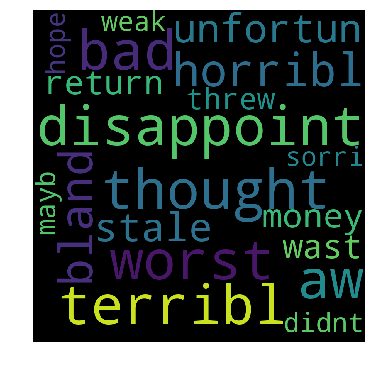

************ Top 20 Positive words *******************


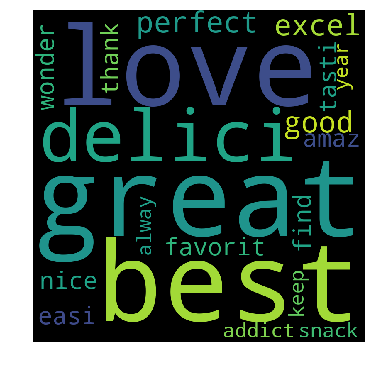

In [43]:
print("************ Top 20 Negative words *******************")
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 10).generate(sn) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5,5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()


print("************ Top 20 Positive words *******************")
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 10).generate(sp) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5,5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [44]:
#Confusion matrix
C = confusion_matrix(y_test, pred_bow)
A =(((C.T)/(C.sum(axis=1))).T)
B =(C/C.sum(axis=0))
labels = [0,1]

-------------------- Confusion matrix --------------------


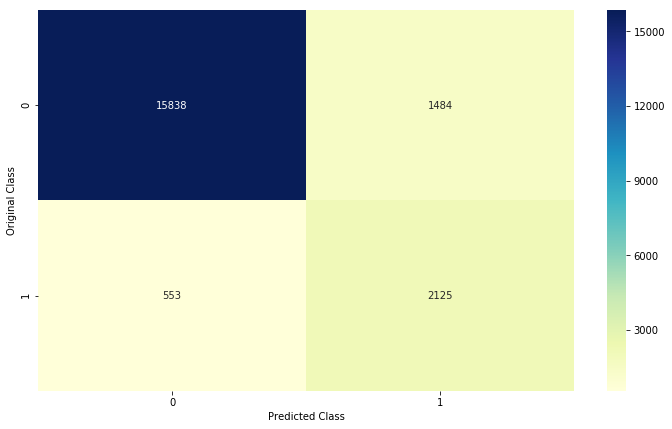

-------------------- Precision matrix (Columm Sum=1) --------------------


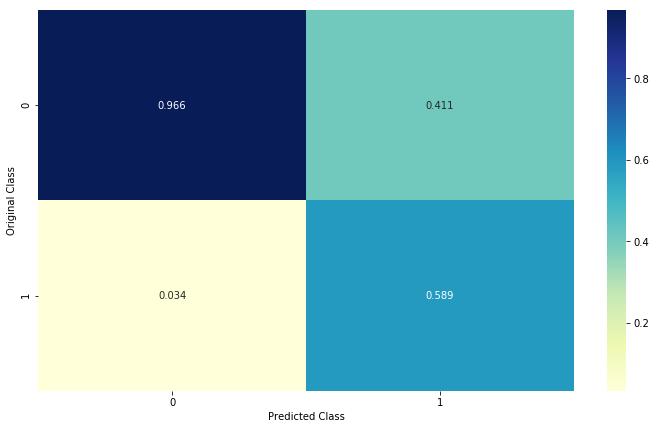

-------------------- Recall matrix (Row sum=1) --------------------


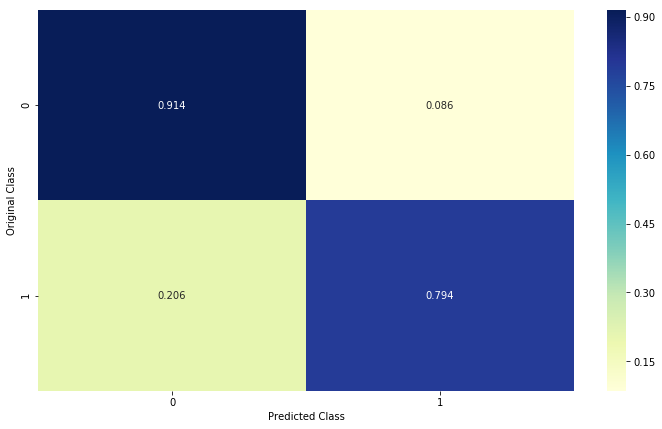

In [45]:
 print("-"*20, "Confusion matrix", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
 plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
    
    # representing B in heatmap format
print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

#### Tf-idf 

In [47]:
#Initiating Vectorizer
count_vect = TfidfVectorizer(ngram_range=(1,2))

#Train data
vocabulary = count_vect.fit(x_train)
Tfidf_x_train= count_vect.transform(x_train)
print("the type of count vectorizer ",type(Tfidf_x_train))
print("the shape of out text BOW vectorizer ",Tfidf_x_train.get_shape())
print("the number of unique words ", Tfidf_x_train.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (80000, 1013943)
the number of unique words  1013943


In [48]:
#Test data
Tfidf_x_test= count_vect.transform(x_test)
print("the type of count vectorizer ",type(Tfidf_x_test))
print("the shape of out text BOW vectorizer ",Tfidf_x_test.get_shape())
print("the number of unique words ", Tfidf_x_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 1013943)
the number of unique words  1013943


In [49]:
#Standardizing 
from sklearn.preprocessing import StandardScaler
Standard=StandardScaler(with_mean=False)
Tfidf_x_train = Standard.fit_transform(Tfidf_x_train)
Tfidf_x_test = Standard.transform(Tfidf_x_test)

print(Tfidf_x_train.shape)
print(Tfidf_x_test.shape)

(80000, 1013943)
(20000, 1013943)


##### Fitting Randomsearch on Tf-Idf

In [55]:
grid.fit(Tfidf_x_train, y_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.5390181835332085
{'class_weight': 'balanced', 'C': 1e-07}


Text(0,0.5,'Cross-Validated Error')

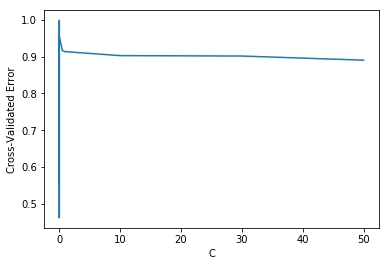

In [56]:
#Plotting C v/s CV_error
a=pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
a['C'] = [d.get('C') for d in a['params']]
b=a.sort_values(['C'])
CV_Error=1-b['mean_test_score']
C =b['C']


plt.plot(C,CV_Error)
plt.xlabel('C')
plt.ylabel('Cross-Validated Error')

In [57]:

#{'class_weight': 'balanced', 'C': 1e-07}
LR_optimal=LogisticRegression(penalty='l2',C=0.0000001,class_weight='balanced')

# fitting the model
LR_optimal.fit(Tfidf_x_train, y_train)

# predict the response
pred_tfidf = LR_optimal.predict(Tfidf_x_test)

# evaluate accuracy
f1_score = f1_score(y_test, pred_tfidf)

# Train & Test Error
print("The overall f1_score for the Train Data is : ", metrics.f1_score(y_train,LR_optimal.predict(Tfidf_x_train)))
print("The overall f1_score for the Test Data is : ", metrics.f1_score(y_test,pred_tfidf))

The overall f1_score for the Train Data is :  0.9030708364732479
The overall f1_score for the Test Data is :  0.5339728217426059


Pertubation test

In [58]:
# Re-training the model after adding noise
Epsilon = np.random.normal(loc=0,scale =0.01)
Noise_Tfidf_x_train=Tfidf_x_train
Noise_Tfidf_x_train.data+=Epsilon

In [59]:

#{'class_weight': 'balanced', 'C': 1e-07}
LR_optimal_noise=LogisticRegression(penalty='l2',C=0.0000001,class_weight='balanced')

# fitting the model
LR_optimal_noise.fit(Noise_Tfidf_x_train, y_train)

# predict the response
pred_tfidf = LR_optimal_noise.predict(Tfidf_x_test)

# evaluate accuracy
f1_score = f1_score(y_test, pred_tfidf)

# Train & Test Error
print("The overall f1_score for the Train Data is : ", metrics.f1_score(y_train,LR_optimal_noise.predict(Noise_Tfidf_x_train)))
print("The overall f1_score for the Test Data is : ", metrics.f1_score(y_test,pred_tfidf))

The overall f1_score for the Train Data is :  0.9030283049969386
The overall f1_score for the Test Data is :  0.5340948029697316


In [60]:
#Features
feature_names = np.array(vocabulary.get_feature_names())
feature_names.shape

(1013943,)

In [61]:
LR_optimal.coef_.shape

(1, 1013943)

In [62]:
LR_optimal_noise.coef_.shape

(1, 1013943)

In [64]:
merge_arr = np.concatenate([LR_optimal.coef_, LR_optimal_noise.coef_], axis=0)
merge=pd.DataFrame(data=merge_arr,columns=feature_names).transpose()
merge[2]=((merge[1]-merge[0])/merge[0])*100
merge

,0,1,2
aaa,-0.000010,-0.000010,0.003393
aaa condit,-0.000008,-0.000008,0.002404
aaa perfect,-0.000008,-0.000008,0.000782
aaaaaaaaagghh,-0.000008,-0.000008,0.000995
aaaaah,-0.000011,-0.000011,0.002724
aaaaah awak,-0.000008,-0.000008,0.000999
aaaaah satisfi,-0.000008,-0.000008,0.002002
aaaaahhhhhhhhhhhhhhhh,-0.000008,-0.000008,0.001810
aaaaahhhhhhhhhhhhhhhh angel,-0.000008,-0.000008,0.001810
aaaah,-0.000007,-0.000007,-0.000594


In [65]:
merge[merge[2]>30].shape

(1, 3)

1 features out of 1013943 shows percentage change > 30 post pertubation test i.e 0%

We can say that our data isn't affected by multicollinearity

In [67]:
feature_names = np.array(vocabulary.get_feature_names())
sorted_coef_index = LR_optimal.coef_[0].argsort()

In [68]:
#Top 20 positive features
p=feature_names[sorted_coef_index[:20]]

sp = ""
for i in p:
    sp += str(i)+","
print(sp)

great,love,best,delici,perfect,favorit,good,find,make,high recommend,easi,excel,wonder,nice,use,snack,alway,keep,add,tasti,


In [69]:
n=feature_names[sorted_coef_index[:-21:-1]]

sn = ""
for i in n:
    sn += str(i)+","
print(sn)

disappoint,wast money,worst,wast,aw,horribl,terribl,return,threw,money,bad,refund,stale,wont buy,thought,mayb,didnt,dont wast,away,wors,


************ Top 20 Negative words *******************


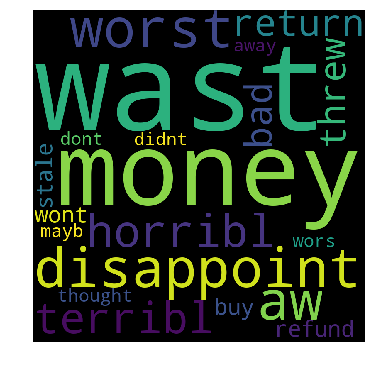

************ Top 20 Positive words *******************


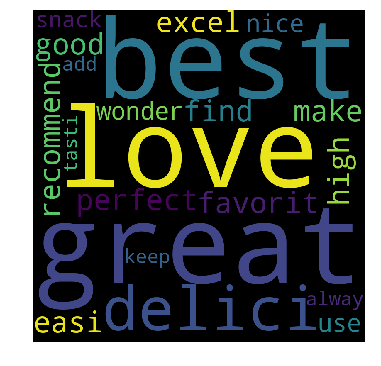

In [70]:
print("************ Top 20 Negative words *******************")
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 10).generate(sn) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5,5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()


print("************ Top 20 Positive words *******************")
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 10).generate(sp) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5,5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [71]:
#Confusion matrix
C = confusion_matrix(y_test, pred_tfidf)
A =(((C.T)/(C.sum(axis=1))).T)
B =(C/C.sum(axis=0))
labels = [0,1]

-------------------- Confusion matrix --------------------


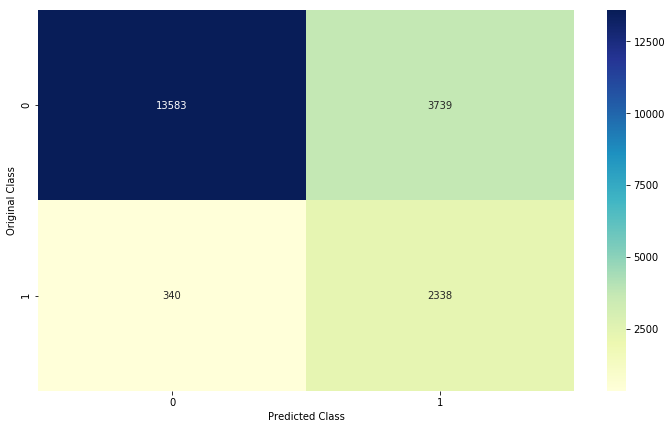

-------------------- Precision matrix (Columm Sum=1) --------------------


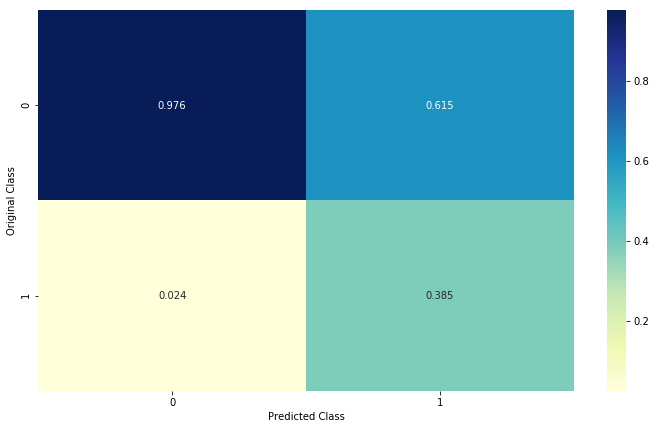

-------------------- Recall matrix (Row sum=1) --------------------


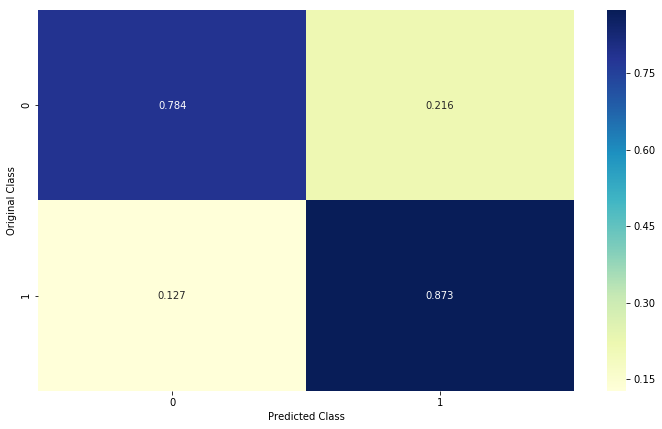

In [72]:
 print("-"*20, "Confusion matrix", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
 plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
    
    # representing B in heatmap format
print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

#### Avg-W2Vec

In [99]:
#W2V list of Training data
i=0
list_of_sent_train=[]
for sent in train_data['CleanedText'].values:
    list_of_sent_train.append(sent.split())

In [100]:
#W2V List of Test data
i=0
list_of_sent_test=[]
for sent in test_data['CleanedText'].values:
    list_of_sent_test.append(sent.split())

In [101]:
#Training W2V train model
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=6)

In [102]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  11361
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool']


In [103]:
#Train data
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train_avgw2v.append(sent_vec)
print(len(sent_vectors_train_avgw2v))
print(len(sent_vectors_train_avgw2v[0]))

80000
50


In [104]:
#Test data
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test_avgw2v.append(sent_vec)
print(len(sent_vectors_test_avgw2v))
print(len(sent_vectors_test_avgw2v[0]))

20000
50


In [105]:
#Standardizing Avg-W2v
from sklearn.preprocessing import StandardScaler

Standard=StandardScaler()
sent_vectors_train_avgw2v = Standard.fit_transform(sent_vectors_train_avgw2v)
sent_vectors_test_avgw2v = Standard.transform(sent_vectors_test_avgw2v)

print(sent_vectors_train_avgw2v.shape)
print(sent_vectors_test_avgw2v.shape)

(80000, 50)
(20000, 50)


#### Fitting grid search on Avg-W2V

In [83]:
grid.fit(sent_vectors_train_avgw2v, y_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.5134126417862019
{'class_weight': 'balanced', 'C': 50}


Text(0,0.5,'Cross-Validated Error')

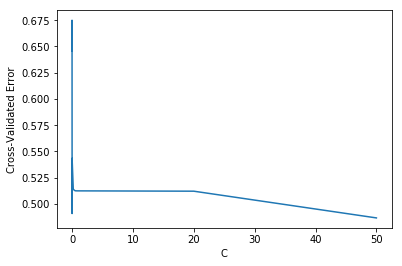

In [84]:
#Plotting C v/s CV_error
a=pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
a['C'] = [d.get('C') for d in a['params']]
b=a.sort_values(['C'])
CV_Error=1-b['mean_test_score']
C =b['C']


plt.plot(C,CV_Error)
plt.xlabel('C')
plt.ylabel('Cross-Validated Error')

In [107]:

#{'class_weight': 'balanced', 'C': 50}
LR_optimal=LogisticRegression(penalty='l2',C=50,class_weight='balanced')

# fitting the model
LR_optimal.fit(sent_vectors_train_avgw2v, y_train)

# predict the response
pred_avg_w2v = LR_optimal.predict(sent_vectors_test_avgw2v)

# evaluate f1_score
f1_score = f1_score(y_test, pred_avg_w2v)

# Train & Test Error
print("The overall f1_score for the Train Data is : ", metrics.f1_score(y_train,LR_optimal.predict(sent_vectors_train_avgw2v)))
print("The overall f1_score for the Test Data is : ", metrics.f1_score(y_test,pred_avg_w2v))

The overall f1_score for the Train Data is :  0.5152863591253961
The overall f1_score for the Test Data is :  0.535966149506347


In [108]:
#Confusion matrix
C = confusion_matrix(y_test, pred_avg_w2v)
A =(((C.T)/(C.sum(axis=1))).T)
B =(C/C.sum(axis=0))
labels = [0,1]

-------------------- Confusion matrix --------------------


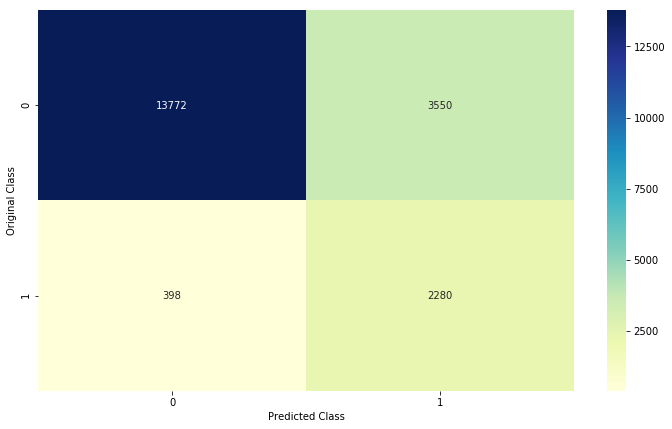

-------------------- Precision matrix (Columm Sum=1) --------------------


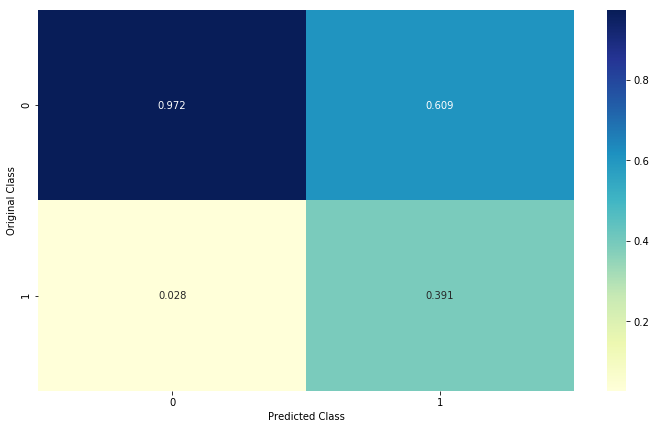

-------------------- Recall matrix (Row sum=1) --------------------


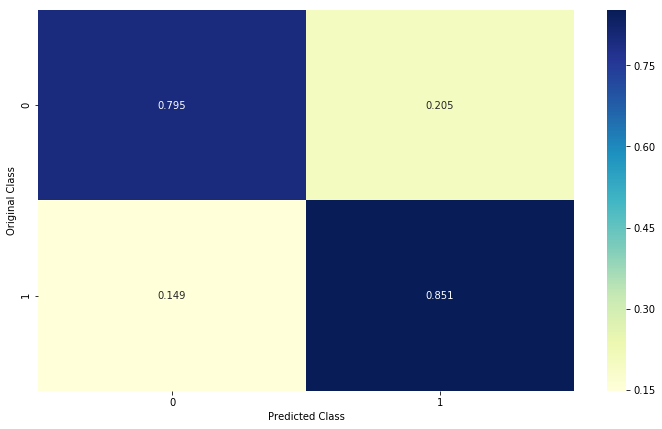

In [109]:
 print("-"*20, "Confusion matrix", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
 plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
    
    # representing B in heatmap format
print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

#### TF-Idf W2Vec 

In [89]:
tf_idf_vect = TfidfVectorizer()
vocabulary = tf_idf_vect.fit(train_data['CleanedText'])
final_tf_idf= tf_idf_vect.transform(train_data['CleanedText'])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(vocabulary.get_feature_names(), list(tf_idf_vect.idf_)))

In [90]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_w2v_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 80000/80000 [01:11<00:00, 1113.33it/s]


In [91]:
final_tf_idf= tf_idf_vect.transform(test_data['CleanedText'])

tfidf_w2v_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:18<00:00, 1080.47it/s]


In [92]:
#Standardizing
from sklearn.preprocessing import StandardScaler

Standard=StandardScaler()
tfidf_w2v_sent_vectors_train = Standard.fit_transform(tfidf_w2v_sent_vectors_train)
tfidf_w2v_sent_vectors_test = Standard.transform(tfidf_w2v_sent_vectors_test)

print(tfidf_w2v_sent_vectors_train.shape)
print(tfidf_w2v_sent_vectors_test.shape)

(80000, 50)
(20000, 50)


#### Fitting grid search cv on tfidf-w2vec

In [94]:
grid.fit(tfidf_w2v_sent_vectors_train, y_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.47618209651423954
{'class_weight': 'balanced', 'C': 0.5}


Text(0,0.5,'Cross-Validated Error')

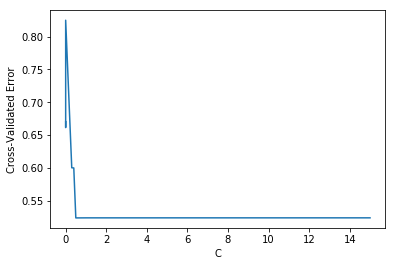

In [95]:
#Plotting C v/s CV_error
a=pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
a['C'] = [d.get('C') for d in a['params']]
b=a.sort_values(['C'])
CV_Error=1-b['mean_test_score']
C =b['C']


plt.plot(C,CV_Error)
plt.xlabel('C')
plt.ylabel('Cross-Validated Error')

In [96]:
#{'class_weight': 'balanced', 'C': 0.5}
LR_optimal=LogisticRegression(penalty='l2',C=0.5,class_weight='balanced')

# fitting the model
LR_optimal.fit(tfidf_w2v_sent_vectors_train, y_train)

# predict the response
pred_tfidf_w2v_sent_vectors_test = LR_optimal.predict(tfidf_w2v_sent_vectors_test)

# evaluate f1_score
f1_score = f1_score(y_test, pred_tfidf_w2v_sent_vectors_test)

# Train & Test Error
print("The overall f1_score for the Train Data is : ", metrics.f1_score(y_train,LR_optimal.predict(tfidf_w2v_sent_vectors_train)))
print("The overall f1_score for the Test Data is : ", metrics.f1_score(y_test,pred_tfidf_w2v_sent_vectors_test))

The overall f1_score for the Train Data is :  0.47774873135475937
The overall f1_score for the Test Data is :  0.5006821282401092


In [97]:
#Confusion matrix
C = confusion_matrix(y_test, pred_tfidf_w2v_sent_vectors_test)
A =(((C.T)/(C.sum(axis=1))).T)
B =(C/C.sum(axis=0))
labels = [0,1]

-------------------- Confusion matrix --------------------


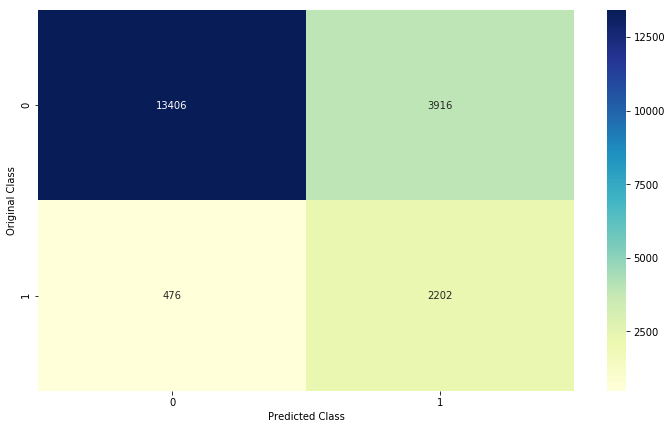

-------------------- Precision matrix (Columm Sum=1) --------------------


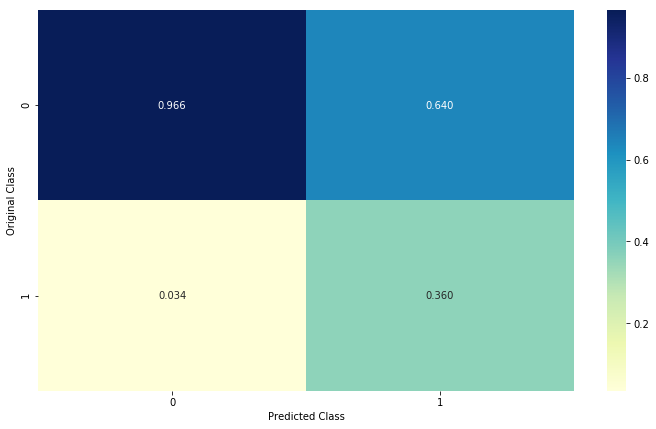

-------------------- Recall matrix (Row sum=1) --------------------


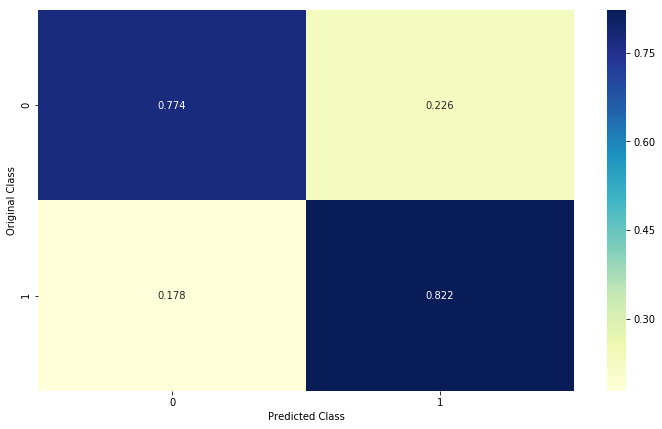

In [98]:
 print("-"*20, "Confusion matrix", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
 plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
    
    # representing B in heatmap format
print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

Reporting f1_score for above featurization with L2 regularizer

In [111]:
from prettytable import PrettyTable

In [112]:
x=PrettyTable()
x.field_names = ["Model","Bow", "Tfidf", "Avg-W2V", "Tfidf-W2V"]
x.add_row(["C",0.01,1e-07,50,0.5])
x.add_row(["Train f1_score",0.80,0.90,0.51,0.47])
x.add_row(["Test f1_score",0.67,0.53,0.53,0.50])

print(x)

+----------------+------+-------+---------+-----------+
|     Model      | Bow  | Tfidf | Avg-W2V | Tfidf-W2V |
+----------------+------+-------+---------+-----------+
|       C        | 0.01 | 1e-07 |    50   |    0.5    |
| Train f1_score | 0.8  |  0.9  |   0.51  |    0.47   |
| Test f1_score  | 0.67 |  0.53 |   0.53  |    0.5    |
+----------------+------+-------+---------+-----------+


********************************************************************************************************************************